## ML models with Dask and xarray

In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight

In [10]:
import dask_ml.cluster

In [11]:
#setup dask client
from dask.distributed import Client
client = Client()

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [12]:
client.cluster

In [13]:
#radar datacube setup
dc = datacube.Datacube(config='radar.conf')

In [14]:
#query for an example area
qtime = ('2016-09-01', '2019-06-01')

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

In [15]:
#load the raw sar scenes as a dask xarray
daskSAR = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query, dask_chunks = {'time': 20})

In [16]:
#is this a dask?
daskSAR.vv.data

dask.array<rechunk-merge, shape=(142, 264, 488), dtype=float32, chunksize=(20, 264, 488)>

In [17]:
#replicate the preprocessing in the non-dask 'clean load' function
#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
daskSAR=daskSAR.where(daskSAR!=0)
clean=rf.denoise(daskSAR)

clean['vh_over_vv'] = clean.vh/clean.vv

In [18]:
#are we still dask?
clean.vh.data

dask.array<where, shape=(142, 264, 488), dtype=float32, chunksize=(20, 264, 488)>

In [19]:
logclean = np.log(clean)

In [20]:
bulknormSAR = rf.bulknorm_SAR_ds(logclean,dask=True)

In [143]:
#can we flatten the underlying array using only xarray methods?
stackedSAR = bulknormSAR.stack(z=['time','x','y']).to_array().T

In [148]:
stackedSAR.data = stackedSAR.data.rechunk((stackedSAR.data.chunksize[0],-1))
stackedSAR.data

dask.array<rechunk-merge, shape=(18294144, 3), dtype=float32, chunksize=(2576640, 3)>

In [159]:
#sklearn and the dask wrapper doesn't handle NaN so we need to do something about that
import dask_ml.impute
#need to do the dask_ml methods on the dask array directly or it loads everything into memory
out = kmm.predict(dask_ml.impute.SimpleImputer().fit_transform(stackedSAR.data))

In [160]:
out_da = stackedSAR.isel(variable=0)
out_da.data=out

In [169]:
out_da=out_da.unstack().transpose('time','y','x')

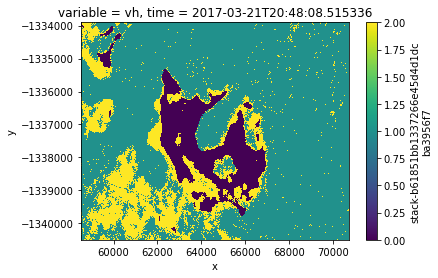

In [171]:
out_da.isel(time=30).plot()

In [60]:
kmm = dask_ml.cluster.KMeans(n_clusters=3,n_jobs=8).fit(noNaNSAR)

In [55]:
kmm.cluster_centers_

array([[-0.24743351,  0.00473711, -0.46834683],
       [-1.0610919 , -1.2232779 ,  0.2869344 ],
       [ 0.31053892,  0.19896658,  0.20957346]], dtype=float32)

In [61]:
kmm.cluster_centers_

array([[-1.0574448 , -1.2266419 ,  0.29991788],
       [ 0.2741689 ,  0.17730744,  0.18199466],
       [-0.2885216 ,  0.00581504, -0.5466568 ]], dtype=float32)

In [115]:
out = kmm.predict(stackedSAR)

In [116]:
out

dask.array<astype, shape=(3,), dtype=int32, chunksize=(1,)>

In [78]:
out = out.reshape((len(sar_array.time),len(sar_array.x),len(sar_array.y),))

In [77]:
import xarray as xr

In [90]:
out_da = xr.DataArray(out, dims=bulknormSAR.dims)

In [92]:
for dim in out_da.dims:
    out_da[dim]=bulknormSAR[dim]

In [96]:
out_da.isel(time=0)

<xarray.DataArray 'reshape-01f59d420d8c6cb4a467c8bc6bbb6bdf' (x: 488, y: 264)>
dask.array<shape=(488, 264), dtype=int32, chunksize=(488, 264)>
Coordinates:
    time     datetime64[ns] 2016-09-28T20:47:53.975363
  * x        (x) float64 5.854e+04 5.856e+04 5.859e+04 ... 7.069e+04 7.071e+04
  * y        (y) float64 -1.34e+06 -1.34e+06 -1.34e+06 ... -1.334e+06 -1.334e+06

In [174]:
out_da.y.min()

<xarray.DataArray 'y' ()>
array(-1340487.5)
Coordinates:
    variable  <U10 'vh'

In [175]:
out_da.y.max()

<xarray.DataArray 'y' ()>
array(-1333912.5)
Coordinates:
    variable  <U10 'vh'